In [3]:
# Load the training images and class labels
import PIL
from os import listdir
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
import pandas as pd
import numpy as np

# Local data directories
DATA_DIR = 'C:/Data/DS_Data/AML_Kaggle'
TRAIN_DIR = DATA_DIR + '/train_set/'
TEST_DIR = DATA_DIR + '/test_set/'

# Maximum number of images to load (there are 30k), set to 0 for all
MAX_IMAGE = 0

# Filter for a subset of labels in the images to load
FILTER_LABEL = ['1','2','3','4','5']#,'6','7','8','9','10']
num_labels = len(FILTER_LABEL)

# load all the training labels
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv', dtype={'label': object})
if (len(FILTER_LABEL) > 0):
    train_labels = train_labels[train_labels['label'].isin(FILTER_LABEL)].copy().reset_index()
print('{} training labels loaded'.format(len(train_labels)))  

# load all the training images
train_images = list()
imcount = 0
if MAX_IMAGE == 0:
    MAX_IMAGE = len(train_labels)

print('Start loading {} images'.format(MAX_IMAGE))
for filename in train_labels['img_name']:
    # Load image
    img = Image.open(TRAIN_DIR + filename)
    
    # Resize image to the same shape
    # TODO: Don't squash all images into the same size
    #img = img.resize((256,256), Image.ANTIALIAS)

    # Convert image to numpy array
    img_data = np.array(img)

    # Store loaded image
    train_images.append(img_data)

    # Show progress
    if imcount % 100 == 0:
        print('Loading at {:.1f}%'.format(imcount/min(len(train_labels), MAX_IMAGE)*100))

    # Stop after X images   
    imcount += 1
    if imcount > MAX_IMAGE:
        print('Reached MAX_IMAGE count of '+str(MAX_IMAGE))
        break

2002 training labels loaded
Start loading 2002 images
Loading at 0.0%
Loading at 5.0%
Loading at 10.0%
Loading at 15.0%
Loading at 20.0%
Loading at 25.0%
Loading at 30.0%
Loading at 35.0%
Loading at 40.0%
Loading at 45.0%
Loading at 50.0%
Loading at 54.9%
Loading at 59.9%
Loading at 64.9%
Loading at 69.9%
Loading at 74.9%
Loading at 79.9%
Loading at 84.9%
Loading at 89.9%
Loading at 94.9%
Loading at 99.9%


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
val_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_split = int(len(train_labels)*0.8)
train_dataframe = train_labels[:train_split][['img_name','label']]
val_dataframe = train_labels[train_split:][['img_name','label']]

train_generator = train_datagen.flow_from_dataframe(
    train_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(255,255),
    batch_size=25,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(255,255),
    batch_size=25,
    class_mode='categorical'
)

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(num_labels, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
inc_history = model.fit_generator(train_generator, validation_data = val_generator, steps_per_epoch = 15, epochs = 15, validation_steps=6)

Found 1601 validated image filenames belonging to 5 classes.
Found 401 validated image filenames belonging to 5 classes.
Epoch 1/15
15/15 [==============================] - 45s 3s/step - loss: 17.4390 - accuracy: 0.3787 - val_loss: 1.3590 - val_accuracy: 0.6800
Epoch 2/15
15/15 [==============================] - 42s 3s/step - loss: 3.4194 - accuracy: 0.5147 - val_loss: 3.4679 - val_accuracy: 0.4867
Epoch 3/15
15/15 [==============================] - 42s 3s/step - loss: 1.4152 - accuracy: 0.6560 - val_loss: 0.6890 - val_accuracy: 0.8067
Epoch 4/15
15/15 [==============================] - 41s 3s/step - loss: 1.9412 - accuracy: 0.6496 - val_loss: 1.5227 - val_accuracy: 0.7067
Epoch 5/15
15/15 [==============================] - 42s 3s/step - loss: 1.3481 - accuracy: 0.7037 - val_loss: 1.6274 - val_accuracy: 0.7267
Epoch 6/15
15/15 [==============================] - 41s 3s/step - loss: 1.1981 - accuracy: 0.7265 - val_loss: 0.9324 - val_accuracy: 0.7600
Epoch 7/15
15/15 [====================

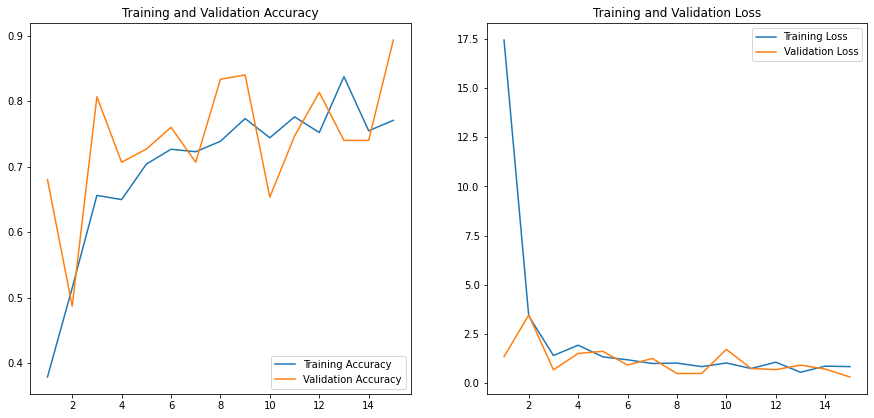

In [7]:
acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']
loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()